# Predicting Common Scope

To predict common scope from home characteristics, I developed a simple `Python` module, stored in a separate file named: [`common_scope.py`](common_scope.py). This python module contains all the necessary functionalities to load, and preprocess the data, as well as modeling and predicting labels.

The main class in the module is called `CommonScope` which includes the engine.

In this vignette, I will explain how to use the class and then I apply the method on the holdout data.

<img src="./images/house.png" alt="House" align="right" style="width: 200px;"/>



### Loading `Matplotlib`

As most of the class are loaded and used in the `CommonScope` module, here I only import `matplotlib` for visualizations.



In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



### Usage

In addition to importing `CommonScope`, I also import a stand-alone function, called `summarize`, located in our module. The main goal of `summarize` is to provide a summary of columns and data types in the training and hold-out datasets.


In [2]:
from common_scope import CommonScope, summarize

To better understand the underlying procedure of our class, please refer to the module file: [`common_scope.py`](common_scope.py). 

The module, its class, methods and functions are documented using standard `Python Docustring`, as suggested by [PEP 257](https://www.python.org/dev/peps/pep-0257/).

### `CommonScope` class instantiation

**Method I**:
The basic mehtod to instantiate the class is very straight-forward by passing the train and hold out files.

The data files get processed and loaded in the class. If any exception occures, it will be caught and messaged to the user.

In [3]:
# loading the class at the time of creating the instance

cs = CommonScope(train_file = 'data/development_df.csv', 
                 holdout_file = 'data/holdout_candidate_df.csv')


"data/development_df.csv" was loaded as the training data set: 10919 x 40
"data/holdout_candidate_df.csv" was loaded as the hold-out data set: 1580 x 39


If things go well, the user sees success messages similar to above.

**Method II**:
Alternatively, these can be done in three steps for more transparency, as follows:

In [4]:
# class instantiation
cs = CommonScope(model = 'Lasso')

# loading the training file
cs.load_data(file_path='data/development_df.csv')

# loading the holdout file
cs.load_data(file_path='data/holdout_candidate_df.csv', holdout = True)


"data/development_df.csv" was loaded as the training data set: 10919 x 40
"data/holdout_candidate_df.csv" was loaded as the hold-out data set: 1580 x 39


### Exploratory the data

To facilitate data exploration, I have customized a method to summarize, data-type, number of unique values and missing fraction for each column in the data. This helps to decide about the modeling structure.

The functionality can be accessed using the `summary` method.

In [12]:
# summarizing the training data

summarize(cs.train_data).head()

,column_name,data_type,unique_values,percent_missing
has_renovation,has_renovation,bool,2,0.0
in_gated_community,in_gated_community,bool,2,0.0
renovation_amount,renovation_amount,int64,40,0.0
pool,pool,float64,2,0.0
total_finished_sq_ft,total_finished_sq_ft,float64,2520,0.0


Similarly, I can quickly explore the hold out data

In [6]:
# summarizing the holdout data
holdout_summary = summarize(cs.holdout_data)

## Data Challenges

There are several challenges of this dataset, that I summarize as follows:

1. Missing data
2. Multifarious data (various types)
3. Multi-Colinearity


### 1. Missing Data
I followed several approaches to address missing data problem:
 - For few columns with more than 40% missing data, I dropped the column.
 - For `integer` data types, I replaced the missing data with the `median` value on the training dataset
 - For `float` data types, I replaced the missing data with the `mean` value on the training dataset
 - For `object` data types, I replaced the missing data with the `most frequent` value on the training dataset
 
**Note:** The gap-filling process was fit on the `training` dataset and then transform on both the `training` and `holdout` data. 
 
 
### 2. Multifarious data (various types)

The original data was in various types, including: `boolean`, `integer`, `float`, `categorical` and `raw (unparsed) text`. Therefore, the data should be preprocessed to be used in the model. I took the following approach:
- `boolean` data were transformed to 0 for False and 1 for True values.
- `integer` data were used as is.
- `float` data were used as is.
- `categorical` data were transoformed to binary matrices, i.e. One-Hot-Encoding.
- `raw (unparsed) text` data were first parsed to extract features and then used as binary matrices.


### 3. Multi-Colinearity:
I took two approaches to tackle this issue:
 - Using regulatization regression method such as *Lass* or *Ridge* Regression methods.
 - or dropping the highly correlated features. 
 
**For the second approach:** 
After preprocessing the feature matrix, I dropped colinear feature using our embeded routine based on a [Variance Inflation Factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) threshold.


This procedure is performed inside the `drop_colinearity` function in the `CommonScope` module.

## Modeling

In the `CommonScope` Class, I implemented three different models as options: Linear Regression, Lasso Regression and Ridge Regression. All three can be easily called eighter when the `__init__` constructor is called or when the `fit` method is called. 

In addition to the these regression models, I also implemented a Neural Network in TensorFlow which does not show significant improvments over the regression methods.

However, I took one step further and only for comparison porpuses, I trained an AutoML model on `Google Cloud Platfrom`. The main challenge for AutoML, however, is that there is little control on model tunning. And there would be an additional cost for modeling and predictions as well as for I/O. So I only compared the results from AutoML to the results from my home-grown `CommonScope` module.


In [14]:
cs.fit(verbose = True, 
       model = 'Lasso')

{'train': {'R²': 0.3554973294967694, 'MAE': 3585.500088635188, 'rMSE': 5003.07800080008}, 'test': {'R²': 0.36139876302514473, 'MAE': 3524.1158468408607, 'rMSE': 4811.016886008233}}


{'model': Lasso(alpha=0.1, normalize=True),
 'model_summary': {'train': {'R²': 0.3554973294967694,
   'MAE': 3585.500088635188,
   'rMSE': 5003.07800080008},
  'test': {'R²': 0.36139876302514473,
   'MAE': 3524.1158468408607,
   'rMSE': 4811.016886008233}}}

## Predictions for the Hold-out Data

In [20]:
holdout_preds = cs.predict(df= cs.holdout_data)

holdout_preds = pd.DataFrame({'flip_token': cs.holdout_data.flip_token.to_list(),
                             'prediction': holdout_preds.reshape(len(holdout_preds))})

holdout_preds.head()



,flip_token,prediction
0,560EQGK7A1YM,8253.744871
1,N283R19X7QWF,7019.699259
2,7HNA53BSS2D92,3604.332270
3,NN5R58HDGFB2,-133.914589
4,2XDMCE3HDXNNP,11610.761356


### Exporting the predictions

In [19]:
holdout_preds.to_csv('data/holdout_predictions.csv', 
                     index = False)

## Comparison against the AutoML model

Below I compare the results from my model with results from an AutoML that I trained on GCP.

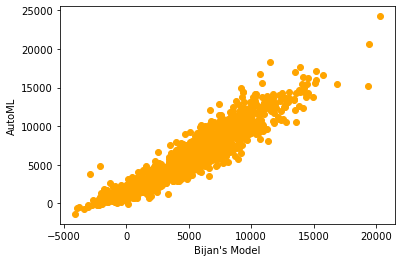

R2 =  0.8055887842606219


In [70]:
automl_pred = pd.read_csv('data/holdout_predictions_automl.csv')

bijan_vs_automl = holdout_preds.merge(automl_pred, 
                                      on= 'flip_token')

plt.plot(bijan_vs_automl.prediction, 
         bijan_vs_automl.automl_predictions, 
         'o', 
         color='orange')

plt.xlabel("Bijan's Model")
plt.ylabel("AutoML")

plt.show()

print('R2 = ', r2_score(bijan_vs_automl.prediction, 
                   bijan_vs_automl.automl_predictions))